env: pythonproject (laptop)
env: Ca_anal (desktop)

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reset', '-sf')

In [2]:
import pandas as pd
import glob
from dash import Dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import re
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, peak_widths
import modules.file_folder_handler as file_folder_handler
import modules.data_transformator as data_transformator
import modules.graph_handler as graph_handler
import modules.peak_detector as peak_detector
import modules.data_uploader as data_uploader
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'notebook'
# %matplotlib inline


In [3]:
data = pd.read_csv(
    'Fluo_mtRCaMP_whole_record\Fluo_mtRCaMP_whole_record.txt', sep='	')
data.head()

,Time,Fluo2,mtRCamp
0,0.00,53.28100,49.37500
1,0.01,55.54272,42.25070
2,0.02,57.43230,35.72124
3,0.03,54.02395,37.65986
4,0.04,52.04270,39.46696


### Поиск бейзлайна и вырезание больших пиков в цитозольном кальции (Fluo2)

1. ищем бейзлайн по всей записи -> 
2. если 100 точек подряд, превышающие бейзлан, то найти начало, где происходит превышение бейзлайна
3. найти конец, превышающее бейзлайн 
4. вырезать этот участок

In [4]:
data.columns[1:]

Index(['Fluo2', 'mtRCamp'], dtype='object')

Найдем бейзлайн для цитозольного кальция

In [5]:
baseline = data['Fluo2'].mean()

найдем начало и конец пика 

In [6]:
def peak_detection(df, bl):
    sns.set_theme(font_scale=1, context='poster', style="ticks")
    plt.Figure(figsize=(10, 30))
    cut_peak = df.loc[0:, 'Fluo2'].reset_index()['Fluo2']
    peaks, properties = find_peaks(cut_peak, prominence=35,
                               wlen=100,
                               height=bl,
                               width=10,
                               rel_height=2.5)

    results_full = peak_widths(cut_peak, peaks, rel_height=1.01, wlen=1500)

    plt.figure(figsize=(40, 5))
    plt.plot(cut_peak)
    plt.plot(peaks, cut_peak[peaks], "x")
    plt.hlines(*results_full[1:], color="C3")
    plt.show()
    return cut_peak,results_full

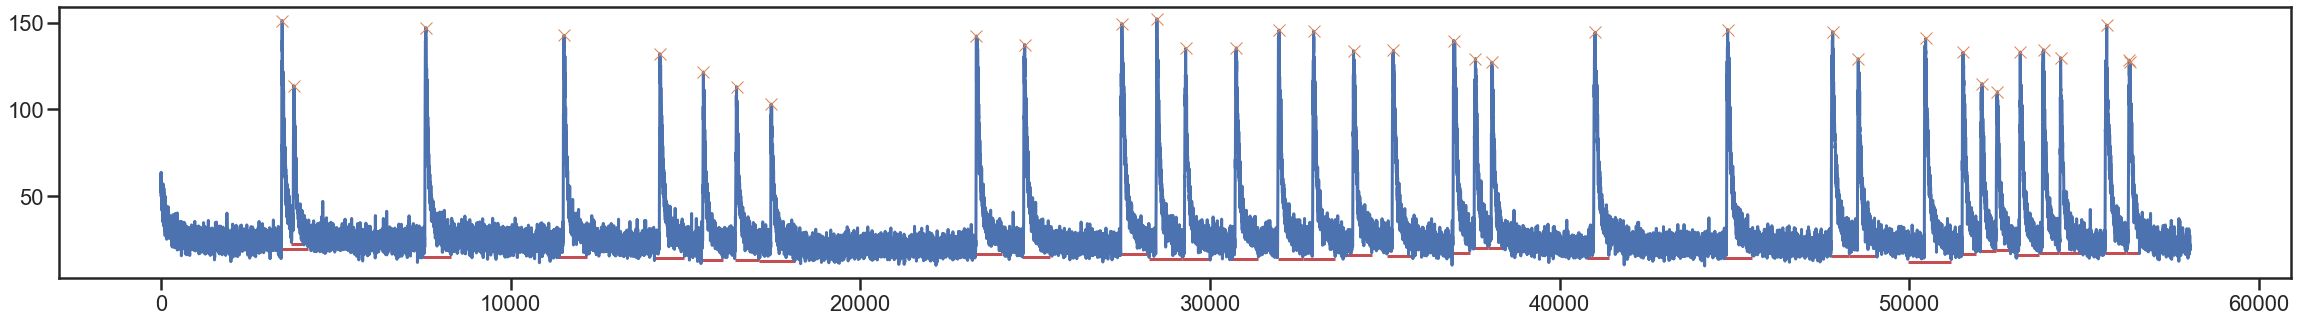

In [7]:
cut_trace, peak_idx  = peak_detection(data, baseline)

In [8]:
def peak_border(peak_index):
    idx = []
    for widths, peak_start, peak_end in zip(peak_index[0], peak_index[2], peak_index[3]):
        if int(widths) >= 100:
            ind_range = list(range(int(peak_start), int(peak_end)))
            idx.extend(ind_range)
    return idx


In [9]:
cut_idx = peak_border(peak_idx)

In [10]:
cut_trace.drop(cut_trace.index[cut_idx], inplace=True)

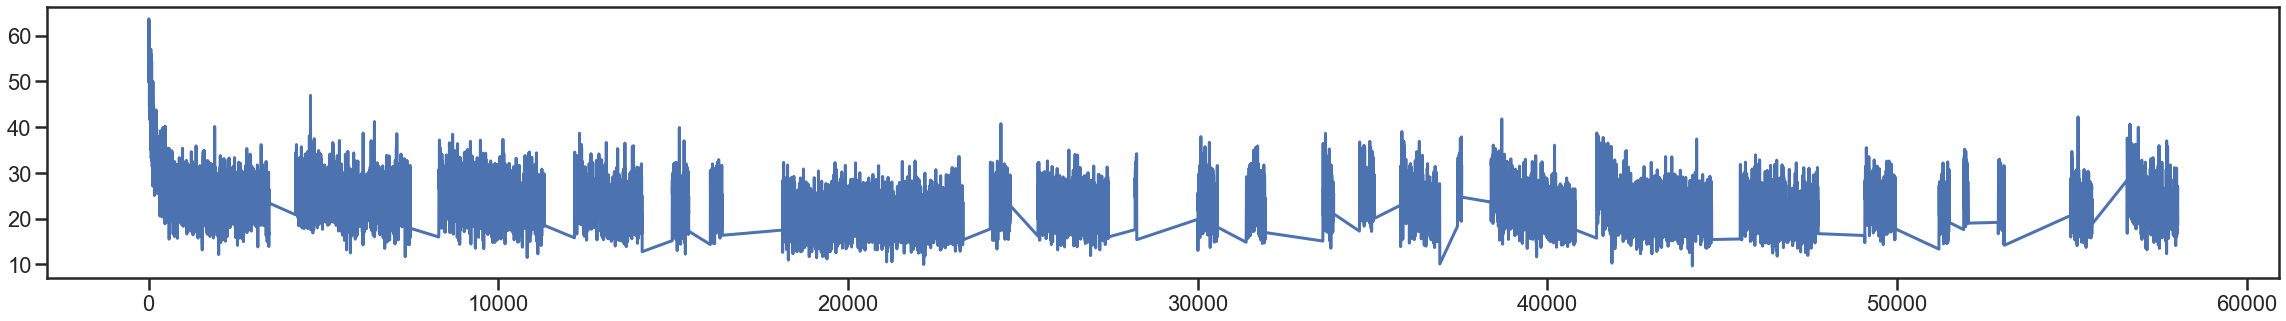

In [11]:
plt.figure(figsize=(40, 5))
plt.plot(cut_trace)


удалим остаток пика в начале

In [12]:
cut_trace = cut_trace.loc[500:]

Если нужна склейка

In [13]:
#cut_trace.reset_index(drop = True, inplace=True)


In [14]:
# plt.figure(figsize=(40,5))
# plt.plot(cut_trace)


### 2. Делим полученную запись на участки по 2сек

In [15]:
def track_slice(df):
    lst = []
    count = 0
    for i in range(len(df)):
        if i%200==0:
            count+=1
        lst.append(count)
    return lst

cut_trace_slice = pd.Series(track_slice(cut_trace.loc[500:]))

In [16]:
cut_trace = pd.DataFrame(cut_trace).join(data['mtRCamp'], on=cut_trace.index)

In [17]:
cut_trace_slice = pd.concat([cut_trace.reset_index(), cut_trace_slice], ignore_index=True, axis = 1)

In [18]:
cut_trace_slice.rename(columns={1: 'Fluo2',2:'mtRCamp', 3: 'slice'}, inplace=True)
cut_trace_slice

,0,Fluo2,mtRCamp,slice
0,500,26.67720,7.60649,1
1,501,28.37336,5.84570,1
2,502,26.63193,7.65163,1
3,503,25.02297,9.23014,1
4,504,25.37812,7.46935,1
...,...,...,...,...
34371,58025,19.90269,15.86798,172
34372,58026,19.25677,13.51119,172
34373,58027,18.64262,9.63395,172
34374,58028,22.53388,12.53550,172


### 3. Строим 2SD для Fluo2 и mtRCamp

Fluo2  - цитозольный кальций

mtRCamp - митохондриальный

In [19]:
cut_trace_slice['slice_index'] = (pd.Series
                                    (np.tile
                                    (np.arange(1, 201), len(cut_trace_slice)//200+1))
                                    .loc[:len(cut_trace_slice)-1])

In [20]:
def to_wide(df):
    cyto = df.pivot_table(index = 'slice_index', columns = 'slice', values = 'Fluo2').reset_index()
    cyto['signal_type'] = 'Fluo2'
    mit = df.pivot_table(index = 'slice_index', columns = 'slice', values = 'mtRCamp').reset_index()
    mit['signal_type'] = 'mtRCamp'
    return pd.concat([cyto,mit], axis = 0)

In [21]:
cut_trace_slice_wide = to_wide(cut_trace_slice)
cut_trace_slice_wide.head()

slice,slice_index,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,172,signal_type
0,1,26.67720,16.61223,23.89435,24.87611,17.14595,20.19327,22.77345,19.93596,27.01582,...,22.33571,22.97534,30.84397,24.30508,22.37612,18.68658,17.20092,22.47942,23.41100,Fluo2
1,2,28.37336,20.17994,20.08173,23.94163,20.00528,19.98338,21.88332,17.51294,29.45784,...,19.76676,20.55233,32.00714,24.65600,26.47131,16.60269,18.79467,23.77183,25.27243,Fluo2
2,3,26.63193,26.30287,19.14280,25.49252,22.83699,20.87188,21.17249,18.59314,25.14480,...,16.45508,23.91396,31.46166,24.65600,31.33388,19.61256,23.28555,25.02102,21.52443,Fluo2
3,4,25.02297,27.29525,20.24135,26.73151,25.53504,21.84119,20.04549,22.93875,22.68460,...,17.76604,29.66519,27.51980,25.17222,28.56536,25.00812,24.50919,26.15162,18.29476,Fluo2
4,5,25.37812,27.19858,22.46490,27.52350,27.69723,23.11669,18.78513,23.13882,23.76661,...,19.35374,30.36935,26.66949,28.38723,25.14046,26.61625,22.55455,26.38991,20.12017,Fluo2


In [22]:
from turtle import width


def sd_graph_saver(df):
    peaks_out = []
    for i in df.columns[1:-1]:
        sns.set_theme(font_scale=1,context = 'notebook', style="ticks")
        mask_cyto = df['signal_type']=='Fluo2'
        mask_mit = df['signal_type']=='mtRCamp'

        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

        #построим графики трейс+/-2SD

        plot1 = sns.lineplot(x=df[mask_cyto]['slice_index'], 
                            y=df[mask_cyto][i],
                            hue = df[mask_cyto]['signal_type'],
                            data=df[mask_cyto],palette='YlGn', ax=ax1)
        
        sd_dendro = df[df['signal_type']=='Fluo2'][i].std()*2 + df[df['signal_type']=='Fluo2'][i].mean()


        plot1.axhline(sd_dendro, 
                            linestyle = '--',
                            color= 'palegreen')
        plot1.axhline(df[df['signal_type']=='Fluo2'][i].mean() - df[df['signal_type']=='Fluo2'][i].std()*2, 
                            linestyle = '--',
                            color= 'palegreen')
        
        plot2 = sns.lineplot(x = df[mask_mit]['slice_index'], 
                    y = df[mask_mit][i],
                    hue = df[mask_mit]['signal_type'],
                    data=df[mask_mit], ax = ax2, palette='pastel')
        plot2.axhline(df[mask_mit][i].std()*2 + df[mask_mit][i].mean(), 
                        linestyle = '--',
                        color = 'skyblue')
        plot2.axhline(df[mask_mit][i].mean() - df[mask_mit][i].std()*2, 
                        linestyle = '--',
                        color = 'skyblue')

        #найдем и отметим пик
        
        x = df[df['signal_type']=='Fluo2'][i]
        peaks, _  = find_peaks(x, height = sd_dendro, distance = 5, width=2 )
        if len(x)!=0: 
            peak_time = df[df['signal_type']=='Fluo2']['slice_index'][peaks]
                #peak_time = peak_time[(peak_time.index>70)&(peak_time.index<130)]
            plot1.plot(peak_time, 
                            x[peaks], 
                            "x", 
                            color = sns.xkcd_rgb['dusty red'])

            plot1.vlines(peak_time, 
                            ymin = df[mask_cyto][i].min(), 
                            ymax = df[mask_cyto][i].max(),
                            linestyle = '--',
                            color= sns.xkcd_rgb['blue'])


            plot2.vlines(peak_time, 
                            ymin = df[mask_mit][i].min(), 
                            ymax = df[mask_mit][i].max(),
                            linestyle = '--',
                            color= sns.xkcd_rgb['blue']) 
        
        #ax1.get_legend().remove()

        
        #ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        #ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax1.get_legend().remove()
        ax2.get_legend().remove()
        ax2.figure.legend(loc=1, bbox_to_anchor=(1.2, 1.0))

        plt.tight_layout()
        #path = save_directory.setdefault(i.split('.')[0])
        save_path = f'fig/Fluo_mtRCaMP_whole_record/{i}'
        #print(save_path)
        #if not os.path.exists(save_path):   ##можно настроить сохранение по папкам
        #    os.makedirs(save_path)
        fig_name = f'{save_path}.tif'
        
        #plt.savefig(fig_name,bbox_inches='tight')  !!!! пока отключила, чтобы каждый раз не сохранять
        plt.rc('figure', max_open_warning = 0)
        plt.close('all')
        peaks_out.append(peaks) 
    return peaks_out

In [23]:
significant_peaks = sd_graph_saver(cut_trace_slice_wide)

### 4.Обрезка найденных пиков

Вырезаем каждый из найденных пиков, чтобы его длительность составляла 300мс

Для начала добавим к датафрейму с вырезанными большими пиками отметки о маленьких пиках. 


In [48]:
cut_trace_slice_wide

slice,slice_index,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,172,signal_type
0,1,26.67720,16.61223,23.89435,24.87611,17.14595,20.19327,22.77345,19.93596,27.01582,...,22.33571,22.97534,30.84397,24.30508,22.37612,18.68658,17.20092,22.47942,23.41100,Fluo2
1,2,28.37336,20.17994,20.08173,23.94163,20.00528,19.98338,21.88332,17.51294,29.45784,...,19.76676,20.55233,32.00714,24.65600,26.47131,16.60269,18.79467,23.77183,25.27243,Fluo2
2,3,26.63193,26.30287,19.14280,25.49252,22.83699,20.87188,21.17249,18.59314,25.14480,...,16.45508,23.91396,31.46166,24.65600,31.33388,19.61256,23.28555,25.02102,21.52443,Fluo2
3,4,25.02297,27.29525,20.24135,26.73151,25.53504,21.84119,20.04549,22.93875,22.68460,...,17.76604,29.66519,27.51980,25.17222,28.56536,25.00812,24.50919,26.15162,18.29476,Fluo2
4,5,25.37812,27.19858,22.46490,27.52350,27.69723,23.11669,18.78513,23.13882,23.76661,...,19.35374,30.36935,26.66949,28.38723,25.14046,26.61625,22.55455,26.38991,20.12017,Fluo2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,6.23858,10.91637,13.04702,10.88767,16.24787,8.70365,13.14343,11.66972,7.64707,...,6.72319,13.59724,12.02568,12.48325,13.65834,12.73767,12.44760,10.57041,NaN,mtRCamp
196,197,8.27387,8.91588,10.41360,6.39628,13.78571,9.43050,12.81217,7.97032,8.71357,...,6.01806,16.40580,10.93359,11.98231,14.94575,12.56035,13.51776,9.18603,NaN,mtRCamp
197,198,10.31955,6.76737,8.35440,11.64889,8.72928,9.78622,12.90935,5.24615,9.41349,...,6.66427,18.89343,10.09352,11.94916,15.86646,13.13913,14.21205,7.82900,NaN,mtRCamp
198,199,12.37139,6.75989,8.40300,16.67973,7.02072,9.85084,11.95171,8.20216,10.07572,...,8.26937,19.93175,10.18755,12.09443,13.78535,15.40086,15.05130,9.49746,NaN,mtRCamp


In [24]:
sig_peak_idx_dict = dict(zip(cut_trace_slice_wide.columns[1:-1], significant_peaks))
sig_peak_df = pd.DataFrame(sig_peak_idx_dict.values(), sig_peak_idx_dict.keys())
sig_peak_df = pd.DataFrame(sig_peak_df.stack()).reset_index()
sig_peak_df.rename(columns = {'level_0': 'slice', 
                    0:'slice_index'}, 
                    inplace=True)
sig_peak_df = sig_peak_df.iloc[:, 0::2]
sig_peak_df = sig_peak_df.astype(int)
sig_peak_df ['peaks'] = 1
sig_peak_df

,slice,slice_index,peaks
0,1,20,1
1,1,38,1
2,1,55,1
3,1,92,1
4,1,163,1
...,...,...,...
576,172,69,1
577,172,84,1
578,172,96,1
579,172,136,1


Точку пика отметим как 1, остальное - 0

In [25]:
cut_trace_slice_with_peaks = cut_trace_slice.merge(sig_peak_df, on = ['slice', 'slice_index'], how = 'left')
cut_trace_slice_with_peaks['peaks'].fillna(0, inplace=True)
cut_trace_slice_with_peaks['peaks'] = cut_trace_slice_with_peaks['peaks'].astype(int)
cut_trace_slice_with_peaks

,0,Fluo2,mtRCamp,slice,slice_index,peaks
0,500,26.67720,7.60649,1,1,0
1,501,28.37336,5.84570,1,2,0
2,502,26.63193,7.65163,1,3,0
3,503,25.02297,9.23014,1,4,0
4,504,25.37812,7.46935,1,5,0
...,...,...,...,...,...,...
34371,58025,19.90269,15.86798,172,172,0
34372,58026,19.25677,13.51119,172,173,0
34373,58027,18.64262,9.63395,172,174,0
34374,58028,22.53388,12.53550,172,175,0


Обрежем найденные пики по 300мс

тут я просто назначу новые индексы точкам рядом с пиком

Этот блок нужно апгрейдить, очень долго. Пока хз как

Мб попробовать добавлять в другие структуры данных? --> поискать потанцевальных кандидатов

Словарь?


In [177]:
def extract_peak(df, trace_lenght):
    diction = {}
    new_df = pd.DataFrame()
    count = 1
    for peaks, index, slice in zip(df['peaks'], df.index, df['slice']):
        if peaks == 1:
            if slice == 1 and index < trace_lenght:
                peak_slice = [0 for _ in range(int(trace_lenght - index))]
                peak_slice.extend(df['Fluo2'].loc[:index + trace_lenght].values)
                diction[count] = peak_slice

            elif slice == df['slice'].iloc[-1] and index > len(df) - trace_lenght:
                peak_slice = list(df['Fluo2'].loc[index - trace_lenght:].values)
                peak_slice.extend([0 for _ in range(int(trace_lenght * 2 + 1 - len(peak_slice)))])
                diction[count] = peak_slice

            elif slice != 1 or slice != df['slice'].iloc[-1]:
                diction[count] = df['Fluo2'].loc[index - trace_lenght : index + trace_lenght].values

            count += 1
    new_df = pd.DataFrame.from_dict(diction)
    return new_df

In [218]:
%%time
half_trace_lenght = 50
peak_extr = extract_peak(cut_trace_slice_with_peaks, half_trace_lenght)

CPU times: total: 78.1 ms
Wall time: 88.8 ms


In [219]:
peak_extr['norm_time'] = np.arange(0,len(peak_extr)*0.01, 0.01)

In [220]:
with pd.ExcelWriter('Fluo_mtRCaMP_whole_record\\extracted_peaks.xlsx') as writer:
    peak_extr.to_excel(writer, sheet_name='peaks', float_format="%.6f")

In [190]:
#peak_extr.columns = peak_extr.columns.astype(str)
#peak_extr.to_parquet('Fluo_mtRCaMP_whole_record\\peak_slices.parquet', compression = 'gzip')

In [212]:
peak_extr = pd.melt(peak_extr, 
            id_vars='norm_time', 
            value_vars= peak_extr.columns[:-1],
            var_name='peak_num',
            value_name='Fluo2')

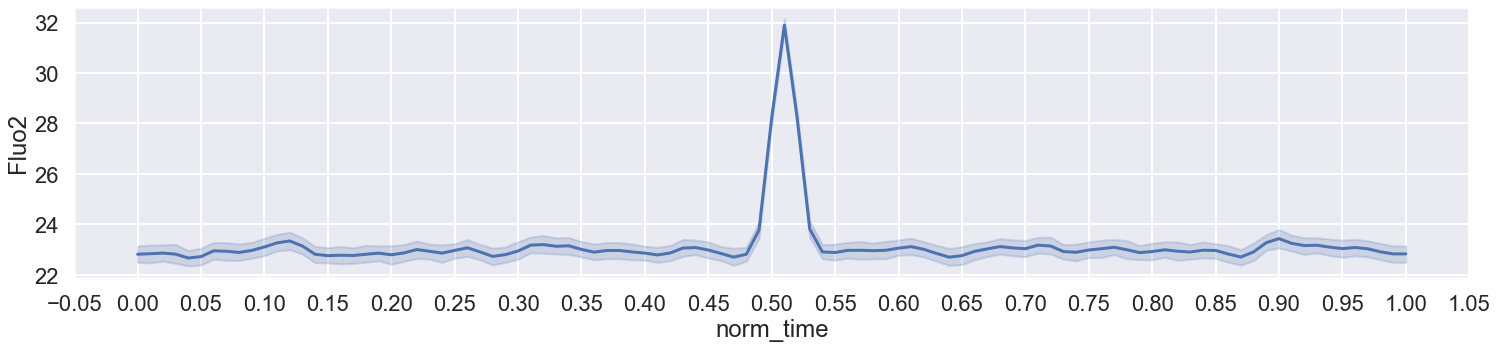

In [216]:
plt.figure(figsize=(25, 5))
sns.set_theme(context = 'poster')
plot = sns.lineplot(data = peak_extr, x = 'norm_time', y = 'Fluo2')
plot.xaxis.set_major_locator(ticker.MultipleLocator(0.05))